# Simulation of SEQUOIA powder experiment

In [1]:
# some goodies
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H

## Create workflow

In [2]:
# Change me
workdir = "/SNS/users/lj7/simulations/SEQUOIA/powder-demo"
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/SEQ/powder-demo


In [16]:
#remove old dir if necessary
#! rm -rf mysim/

In [4]:
!mcvine workflow powder --instrument=SEQUOIA --sample=V --workdir=mysim

In [5]:
!ls mysim/

beam	    debug-scatter  README.md   sampleassembly  sss	test-scatter
create-nxs  Makefile	   reduce2iqe  scatter	       sss.pml


## Beam simulation

In [6]:
# change to beam sim directory
%cd {workdir}/mysim/beam

/SNS/users/lj7/simulations/SEQ/powder-demo/mysim/beam


In [7]:
# show the simulation script
!cat run-beam.sh

#!/usr/bin/env bash
# run 
#   mcvine instruments sequoia beam -h 
# for more options
#
mcvine instruments sequoia beam --keep-in-cache --use-cache --ncount=1e8



In [8]:
!mcvine instruments sequoia beam -h


Simulate SEQUOIA beam.

It is a wrapper of sequoia-m2s and convenient tools to 
compute monitor spectra and others.

Example:

 $ sequoia_beam --fermi_chopper=100-2.03-AST --fermi_nu=600 --T0_nu=60 --E=600 --ncount=1e8

For more details of cmd line parameters, run:

 $ sequoia_beam --help-properties

Impl notes:
* The postprocessing happens in mcvine.instruments.SEQUOIA.beam_postprocessing.



** modify the simulation script (desired incident energy, neutron count) **

In [19]:
%%file run-beam.sh
#!/usr/bin/env bash

mcvine instruments sequoia beam -E=70 --ncount=1e8 --nodes=10

Overwriting run-beam.sh


In [ ]:
# remove output from previous runs if necessary
# !rm -rf *out

In [22]:
%%time
# run simulation
!./run-beam.sh >log.run-beam

/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/mcni/pyre_support/MpiApplication.py:87: UserWarning: no point to run in parallel mode when using just one node
  warnings.warn("no point to run in parallel mode when using just one node")
/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. shoul

After the beam simulation is done
* The main output are in the new folder "out".
* The ".h5" files are histograms of various sorts.
* The "neutron" file is the simulated neutrons of the beam incident on the sample

In [23]:
!ls out

ienergy.h5  ix_divy.h5	iy_divy.h5	      neutrons
itof.h5     ix_y.h5	mon1-itof-focused.h5  props.json
ix_divx.h5  iy_divx.h5	mon2-itof-focused.h5  rank0-step0


<IPython.core.display.Javascript object>


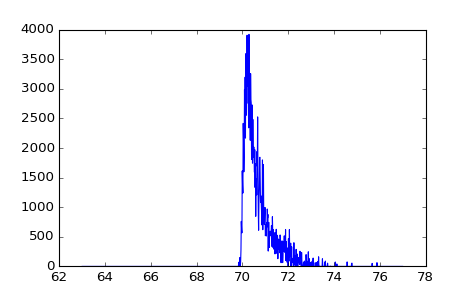

In [24]:
# plot I(E) spectrum
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

<IPython.core.display.Javascript object>


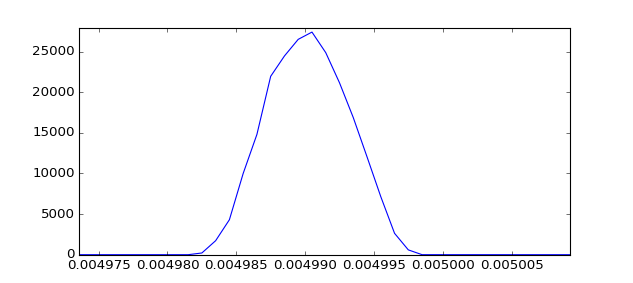

In [25]:
# plot monitor 1 I(tof) spectrum
m1 = hh.load("out/mon1-itof-focused.h5")
plt.plot(m1.tof, m1.I)

## Scattering simulation and reduction

The simulation directory contains a Makefile and various scripts to make it easy to run the simulation and analsysis.

In [26]:
%cd {workdir}/mysim
!ls

/SNS/users/lj7/simulations/SEQ/powder-demo/mysim
beam	    debug-scatter  README.md   sampleassembly  sss	test-scatter
create-nxs  Makefile	   reduce2iqe  scatter	       sss.pml


In [42]:
# Change simulation parameters

In [43]:
%%file Makefile
# -*- Makefile -*-

# *** modifye the following if running mannualy ***
# *** or use command line to change them.       ***
INSTRUMENT=sequoia
NCOUNT=1e7
BUFFER_SIZE=1000000
NODES=10
QAXIS=0 8 0.1


# default rule: we want I(Q,E)
all: IQE

# clean up
clean:
	rm -rf out work-* log.* *~ *.h5 *.nxs

# this rule restore this directory back to the original state of template
# don't do this unless you know what you are doing
restore-template: clean
	rm -f beam
	rm -rf sampleassembly
	rm -rf *.nxs *.h5


plot-iqe: IQE
	plothist --min=0 iqe.h5

# IQE comes from iqe histogram file
IQE: iqe.h5

# iqe histogram comes from reduction of simulated event mode nexus file
iqe.h5: sim.nxs
	INSTRUMENT=$(INSTRUMENT) QAXIS="$(QAXIS)" ./reduce2iqe >log.reduce 2>&1

# nexus file comes from collecting scattered neutrons at the detector system
sim.nxs: out/scattered-neutrons
	INSTRUMENT=$(INSTRUMENT) NODES=$(NODES) ./create-nxs </dev/null >log.create-nxs 2>&1

# scattered neutrons comes from simulation of scattering of incident beam by sample assembly
out/scattered-neutrons: beam sampleassembly sampleassembly/*
	NCOUNT=$(NCOUNT) BUFFER_SIZE=$(BUFFER_SIZE) NODES=$(NODES) ./scatter </dev/null >log.scatter 2>&1

# Required inputs
beam:
	@echo "** Missing incident beam"
	@echo "** Please create a symbolic link to the incident beam"
	@echo "** For example: ln -s ~/simulations/ARCS/beam/688meV beam"
	exit 1

sampleassembly:
	@echo "** Missing sample assembly"
	@echo "** Please create a sampleassembly directory."
	@echo "** You can do this by copying, for example: cp -a ~/simulations/ARCS/He4/sim/template/sampleassembly ."
	exit 1


Overwriting Makefile


In [47]:
%%time
# run simulation and reduction
!chmod +x scatter sss reduce2iqe create-nxs
!make

NCOUNT=1e7 BUFFER_SIZE=1000000 NODES=10 ./scatter </dev/null >log.scatter 2>&1
INSTRUMENT=sequoia NODES=10 ./create-nxs </dev/null >log.create-nxs 2>&1
INSTRUMENT=sequoia QAXIS="0 8 0.1" ./reduce2iqe >log.reduce 2>&1
CPU times: user 9.81 s, sys: 1.34 s, total: 11.2 s
Wall time: 9min 46s


plot z in (0, 1e-07)


<IPython.core.display.Javascript object>


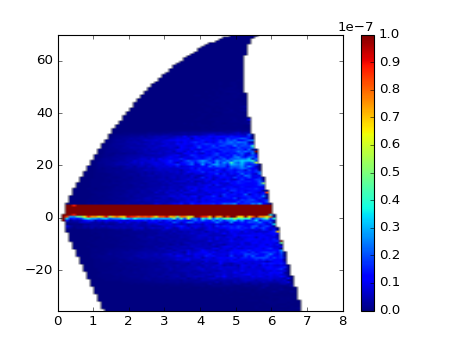

In [48]:
iqe = hh.load("iqe.h5")
H.plot(iqe, min=0, max=1e-7)